### Imports and Hyperparameters

In [1]:
import imgaug as ia
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

%matplotlib inline

In [2]:
import config

### A visualization helper function

In [3]:
def display_image(image, boxes=None, box_color=[0, 0, 255], box_thickness=3, ax=None):
    image = np.array(image)
    
    if boxes is not None:
        boxes = np.array(boxes)[..., :5]
        boxes = [ia.BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=config.CLASSES[int(label)])
                 for x1, y1, x2, y2, label in boxes]
        boxes = ia.BoundingBoxesOnImage(boxes, shape=image.shape)
        image = boxes.draw_on_image(image, color=box_color,
                                    size=box_thickness)
    
    if ax is None:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image)
        ax.axis('off')

### Load and visualize some images

Visualize some REAL images with their boxes for sanity checking 

Loaded 10345 image samples
Loaded 1000 image samples


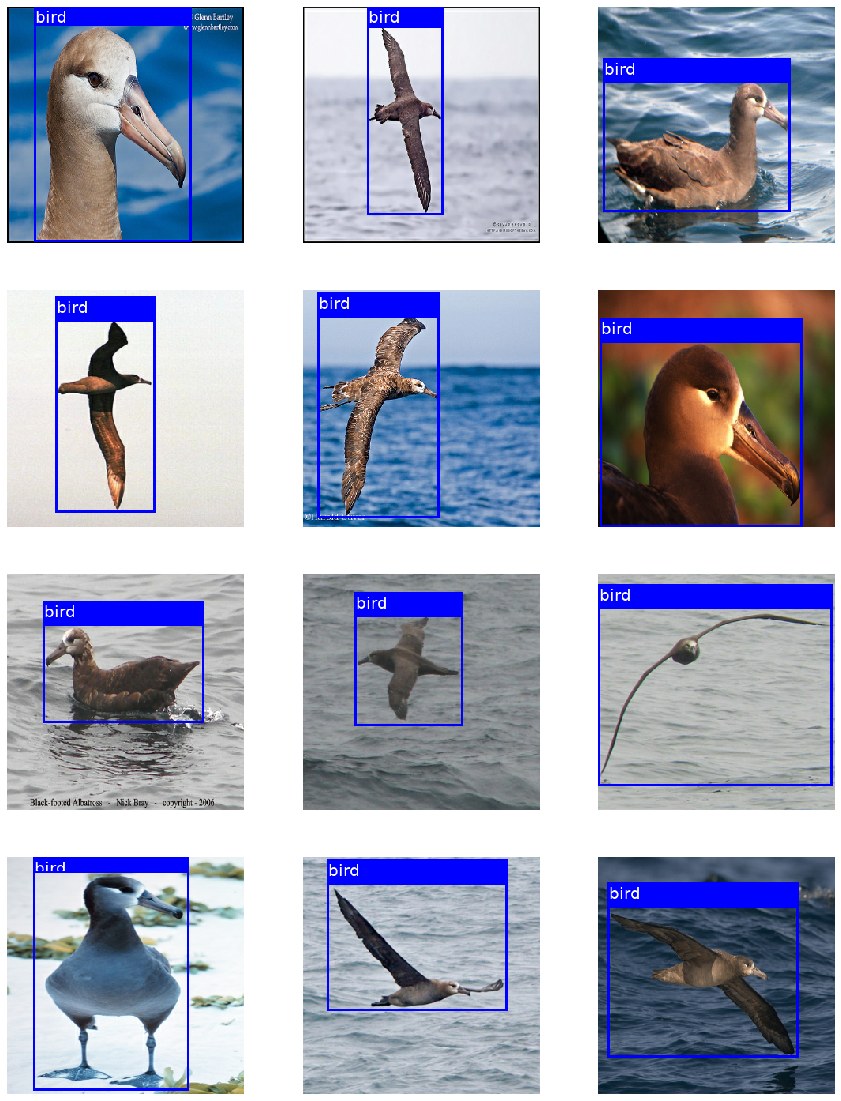

In [4]:
from birds_loader import load_birds, build_dataset

train_image_paths, train_bnd_boxes = load_birds(split='train')
valid_image_paths, valid_bnd_boxes = load_birds(split='valid')

data = build_dataset(train_image_paths, train_bnd_boxes,
                    image_size=config.IMAGE_SIZE)

num_display = 12
num_cols = 3
num_rows = (num_display+1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(data)

for idx in range(num_display):
    x, y = next(data_iter)
    display_image(x, y.to_tensor(), ax=fig.axes[idx])
    
plt.show()

## MobileNet

### Instantiate the model

In [5]:
from ssd_utils.networks.ssd_mobilenet import SSDMobileNet

model = SSDMobileNet(num_classes=len(config.CLASSES), name='ssd_mobilenet')

### Create the data pipelines

In [6]:
anchors = model.get_anchors(image_shape=config.IMAGE_SIZE + (3,))

train_data = build_dataset(train_image_paths, train_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=True, shuffle=True,
                           encode_output=True,
                           anchors=anchors,
                           model=model)

valid_data = build_dataset(valid_image_paths, valid_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=False, shuffle=False,
                           encode_output=False)

for data in [train_data, valid_data]:
    x, y = next(iter(data))
    print(x.shape, y.shape)

(16, 300, 300, 3) (16, 2430, 6)
(16, 300, 300, 3) (16, None, None)


### Train the model

In [7]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('baseline_mobilenet.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(train_data, epochs=config.NUM_EPOCHS,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/40
25/25 [==============================] - ETA: 0s - loss: 19.4342

Calculating Average Precision...: 0it [00:00, ?it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:00, 2867.97it/s]


25/25 [==============================] - 36s 1s/step - loss: 19.4342 - val_meanAP: 0.0032
Epoch 2/40
25/25 [==============================] - ETA: 0s - loss: 7.0320

Calculating Average Precision...: 89it [00:00, 868.53it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 856.63it/s]


25/25 [==============================] - 27s 1s/step - loss: 7.0320 - val_meanAP: 0.0345
Epoch 3/40
25/25 [==============================] - ETA: 0s - loss: 5.3269

Calculating Average Precision...: 45it [00:00, 424.95it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 387.29it/s]


25/25 [==============================] - 31s 1s/step - loss: 5.3269 - val_meanAP: 0.0870
Epoch 4/40
25/25 [==============================] - ETA: 0s - loss: 4.1421

Calculating Average Precision...: 34it [00:00, 333.46it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 276.16it/s]


25/25 [==============================] - 52s 2s/step - loss: 4.1421 - val_meanAP: 0.1875
Epoch 5/40
25/25 [==============================] - ETA: 0s - loss: 3.6973

Calculating Average Precision...: 35it [00:00, 341.99it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 314.42it/s]


25/25 [==============================] - 39s 2s/step - loss: 3.6973 - val_meanAP: 0.2722
Epoch 6/40
25/25 [==============================] - ETA: 0s - loss: 3.3267

Calculating Average Precision...: 32it [00:00, 313.06it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 302.55it/s]


25/25 [==============================] - 40s 2s/step - loss: 3.3267 - val_meanAP: 0.3294
Epoch 7/40
25/25 [==============================] - ETA: 0s - loss: 2.8748

Calculating Average Precision...: 24it [00:00, 238.97it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:04, 218.20it/s]

25/25 [==============================] - 41s 2s/step - loss: 2.8748 - val_meanAP: 0.2751


Epoch 8/40
25/25 [==============================] - ETA: 0s - loss: 2.1757

Calculating Average Precision...: 24it [00:00, 239.13it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:04, 205.35it/s]


25/25 [==============================] - 44s 2s/step - loss: 2.1757 - val_meanAP: 0.3389
Epoch 9/40
25/25 [==============================] - ETA: 0s - loss: 2.2273

Calculating Average Precision...: 27it [00:00, 268.05it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 262.75it/s]


25/25 [==============================] - 52s 2s/step - loss: 2.2273 - val_meanAP: 0.4355
Epoch 10/40
25/25 [==============================] - ETA: 0s - loss: 2.1099

Calculating Average Precision...: 28it [00:00, 277.95it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 265.02it/s]


25/25 [==============================] - 40s 2s/step - loss: 2.1099 - val_meanAP: 0.5330
Epoch 11/40
25/25 [==============================] - ETA: 0s - loss: 2.0439

Calculating Average Precision...: 29it [00:00, 286.35it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 297.51it/s]

25/25 [==============================] - 36s 1s/step - loss: 2.0439 - val_meanAP: 0.5248


Epoch 12/40
25/25 [==============================] - ETA: 0s - loss: 1.7983

Calculating Average Precision...: 25it [00:00, 248.92it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:04, 246.18it/s]


25/25 [==============================] - 38s 2s/step - loss: 1.7983 - val_meanAP: 0.5370
Epoch 13/40
25/25 [==============================] - ETA: 0s - loss: 1.7121

Calculating Average Precision...: 31it [00:00, 307.24it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 296.91it/s]


25/25 [==============================] - 36s 1s/step - loss: 1.7121 - val_meanAP: 0.6093
Epoch 14/40
25/25 [==============================] - ETA: 0s - loss: 1.5959

Calculating Average Precision...: 32it [00:00, 312.10it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 338.59it/s]


25/25 [==============================] - 33s 1s/step - loss: 1.5959 - val_meanAP: 0.6481
Epoch 15/40
25/25 [==============================] - ETA: 0s - loss: 1.4675

Calculating Average Precision...: 32it [00:00, 316.63it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 336.29it/s]


25/25 [==============================] - 33s 1s/step - loss: 1.4675 - val_meanAP: 0.7051
Epoch 16/40
25/25 [==============================] - ETA: 0s - loss: 1.3572

Calculating Average Precision...: 27it [00:00, 267.29it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 311.43it/s]


25/25 [==============================] - 36s 1s/step - loss: 1.3572 - val_meanAP: 0.7846
Epoch 17/40
25/25 [==============================] - ETA: 0s - loss: 1.2241

Calculating Average Precision...: 45it [00:00, 440.73it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 460.59it/s]


25/25 [==============================] - 32s 1s/step - loss: 1.2241 - val_meanAP: 0.8069
Epoch 18/40
25/25 [==============================] - ETA: 0s - loss: 1.4185

Calculating Average Precision...: 33it [00:00, 328.20it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 388.14it/s]

25/25 [==============================] - 32s 1s/step - loss: 1.4185 - val_meanAP: 0.7905


Epoch 19/40
25/25 [==============================] - ETA: 0s - loss: 1.4557

Calculating Average Precision...: 30it [00:00, 293.68it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 355.57it/s]

25/25 [==============================] - 33s 1s/step - loss: 1.4557 - val_meanAP: 0.7812


Epoch 20/40
25/25 [==============================] - ETA: 0s - loss: 1.2695

Calculating Average Precision...: 34it [00:00, 332.52it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 397.65it/s]


25/25 [==============================] - 32s 1s/step - loss: 1.2695 - val_meanAP: 0.8562
Epoch 21/40
25/25 [==============================] - ETA: 0s - loss: 1.2151

Calculating Average Precision...: 49it [00:00, 487.80it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 515.50it/s]


25/25 [==============================] - 31s 1s/step - loss: 1.2151 - val_meanAP: 0.8854
Epoch 22/40
25/25 [==============================] - ETA: 0s - loss: 1.1032

Calculating Average Precision...: 37it [00:00, 369.56it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 488.67it/s]


25/25 [==============================] - 33s 1s/step - loss: 1.1032 - val_meanAP: 0.9003
Epoch 23/40
25/25 [==============================] - ETA: 0s - loss: 1.0386

Calculating Average Precision...: 47it [00:00, 449.37it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 488.68it/s]

25/25 [==============================] - 32s 1s/step - loss: 1.0386 - val_meanAP: 0.8951


Epoch 24/40
25/25 [==============================] - ETA: 0s - loss: 1.0484

Calculating Average Precision...: 54it [00:00, 531.18it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 535.07it/s]


25/25 [==============================] - 33s 1s/step - loss: 1.0484 - val_meanAP: 0.9163
Epoch 25/40
25/25 [==============================] - ETA: 0s - loss: 1.2772

Calculating Average Precision...: 47it [00:00, 459.50it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 523.21it/s]


25/25 [==============================] - 33s 1s/step - loss: 1.2772 - val_meanAP: 0.9236
Epoch 26/40
25/25 [==============================] - ETA: 0s - loss: 1.1476

Calculating Average Precision...: 50it [00:00, 495.55it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 553.04it/s]

25/25 [==============================] - 31s 1s/step - loss: 1.1476 - val_meanAP: 0.9053


Epoch 27/40
25/25 [==============================] - ETA: 0s - loss: 1.1915

Calculating Average Precision...: 47it [00:00, 462.23it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 456.32it/s]


25/25 [==============================] - 32s 1s/step - loss: 1.1915 - val_meanAP: 0.9124
Epoch 28/40
25/25 [==============================] - ETA: 0s - loss: 1.0762

Calculating Average Precision...: 65it [00:00, 645.90it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 639.82it/s]


25/25 [==============================] - 32s 1s/step - loss: 1.0762 - val_meanAP: 0.9265
Epoch 29/40
25/25 [==============================] - ETA: 0s - loss: 1.1705

Calculating Average Precision...: 45it [00:00, 439.43it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 463.52it/s]

25/25 [==============================] - 32s 1s/step - loss: 1.1705 - val_meanAP: 0.8874


Epoch 30/40
25/25 [==============================] - ETA: 0s - loss: 1.0466

Calculating Average Precision...: 40it [00:00, 395.05it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 481.59it/s]

25/25 [==============================] - 33s 1s/step - loss: 1.0466 - val_meanAP: 0.9252


Epoch 31/40
25/25 [==============================] - ETA: 0s - loss: 1.1116

Calculating Average Precision...: 41it [00:00, 404.87it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 572.73it/s]


25/25 [==============================] - 33s 1s/step - loss: 1.1116 - val_meanAP: 0.9277
Epoch 32/40
25/25 [==============================] - ETA: 0s - loss: 1.1111

Calculating Average Precision...: 47it [00:00, 457.46it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 458.18it/s]

25/25 [==============================] - 32s 1s/step - loss: 1.1111 - val_meanAP: 0.9251


Epoch 33/40
25/25 [==============================] - ETA: 0s - loss: 1.0712

Calculating Average Precision...: 46it [00:00, 455.78it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 520.04it/s]

25/25 [==============================] - 34s 1s/step - loss: 1.0712 - val_meanAP: 0.8883


Epoch 34/40
25/25 [==============================] - ETA: 0s - loss: 0.8170

Calculating Average Precision...: 36it [00:00, 351.49it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 482.02it/s]

25/25 [==============================] - 34s 1s/step - loss: 0.8170 - val_meanAP: 0.8665


Epoch 35/40
25/25 [==============================] - ETA: 0s - loss: 1.0246

Calculating Average Precision...: 38it [00:00, 374.93it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 531.06it/s]


25/25 [==============================] - 30s 1s/step - loss: 1.0246 - val_meanAP: 0.9330
Epoch 36/40
25/25 [==============================] - ETA: 0s - loss: 0.9349

Calculating Average Precision...: 48it [00:00, 470.69it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 597.93it/s]


25/25 [==============================] - 33s 1s/step - loss: 0.9349 - val_meanAP: 0.9629
Epoch 37/40
25/25 [==============================] - ETA: 0s - loss: 0.9911

Calculating Average Precision...: 65it [00:00, 645.37it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 681.66it/s]

25/25 [==============================] - 32s 1s/step - loss: 0.9911 - val_meanAP: 0.9385


Epoch 38/40
25/25 [==============================] - ETA: 0s - loss: 0.8655

Calculating Average Precision...: 53it [00:00, 528.42it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 607.32it/s]

25/25 [==============================] - 32s 1s/step - loss: 0.8655 - val_meanAP: 0.9576


Epoch 39/40
25/25 [==============================] - ETA: 0s - loss: 0.8855

Calculating Average Precision...: 54it [00:00, 536.35it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 695.83it/s]


25/25 [==============================] - 32s 1s/step - loss: 0.8855 - val_meanAP: 0.9686
Epoch 40/40
25/25 [==============================] - ETA: 0s - loss: 0.8715

Calculating Average Precision...: 74it [00:00, 739.07it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 702.63it/s]

25/25 [==============================] - 30s 1s/step - loss: 0.8715 - val_meanAP: 0.9618


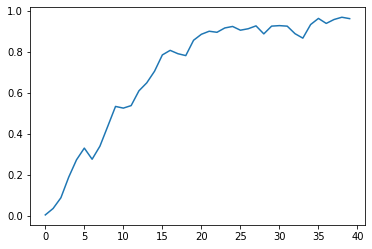

In [9]:
plt.plot(history.history['val_meanAP'])

Calculating Average Precision...: 59it [00:00, 588.70it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 759.17it/s]


Validation meanAP: tf.Tensor(0.9686173320765412, shape=(), dtype=float64)


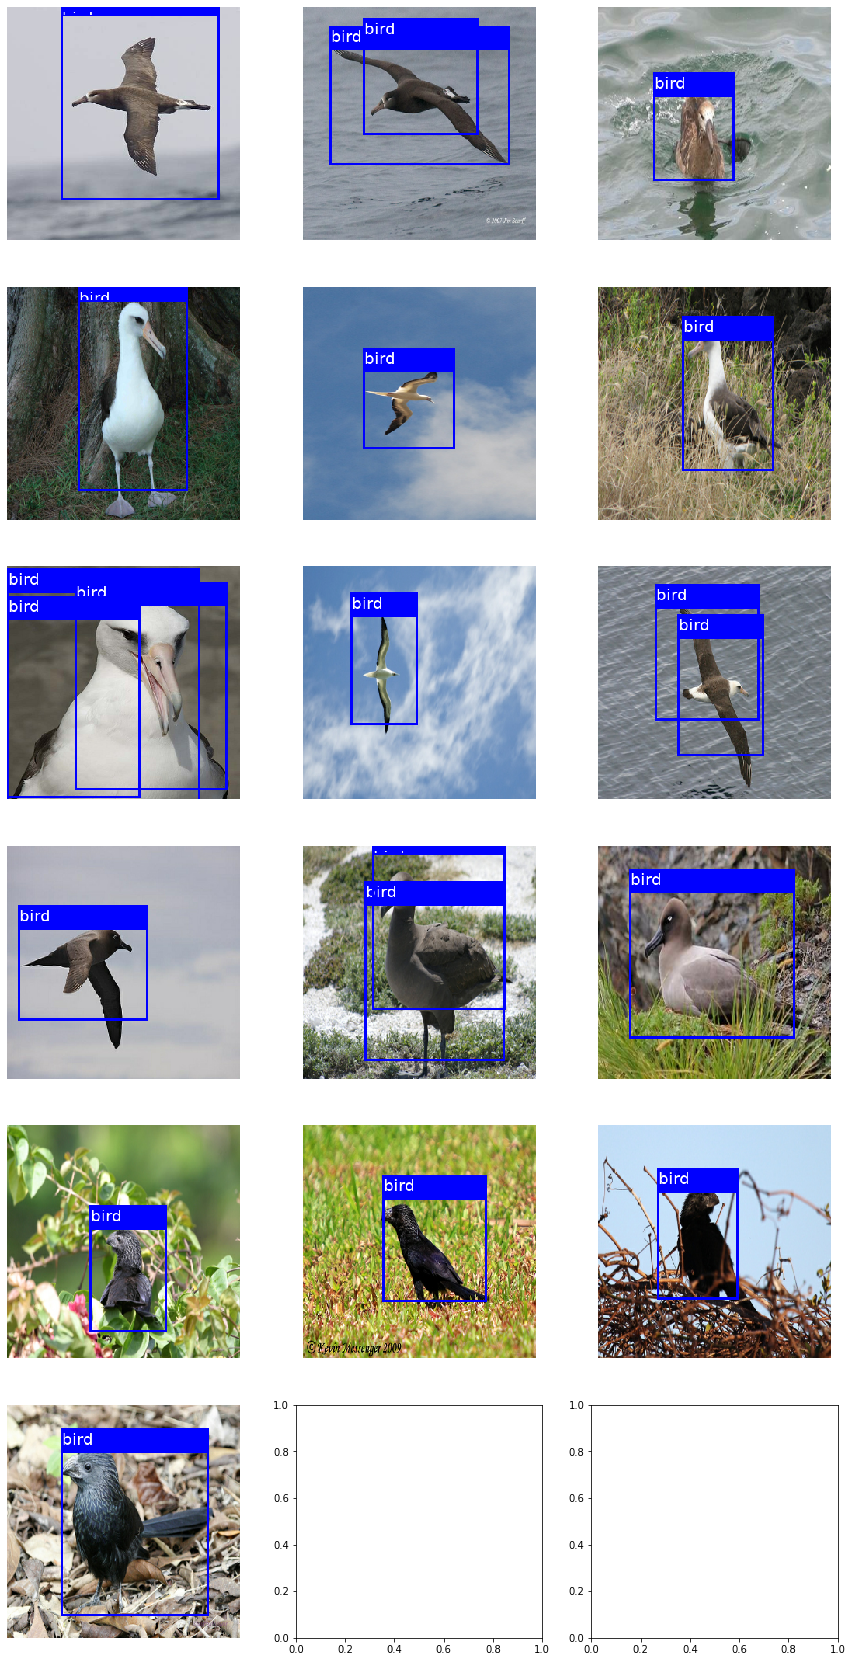

In [10]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'baseline_mobilenet.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()

## ResNet50

### Instantiate the model

In [5]:
from ssd_utils.networks.ssd_resnet50 import SSDResNet50

model = SSDResNet50(num_classes=len(config.CLASSES), name='ssd_resnet50')

### Create the data pipelines

In [6]:
anchors = model.get_anchors(image_shape=config.IMAGE_SIZE + (3,))

train_data = build_dataset(train_image_paths, train_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=True, shuffle=True,
                           encode_output=True,
                           anchors=anchors,
                           model=model)

valid_data = build_dataset(valid_image_paths, valid_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=False, shuffle=False,
                           encode_output=False)

for data in [train_data, valid_data]:
    x, y = next(iter(data))
    print(x.shape, y.shape)

(16, 300, 300, 3) (16, 4149, 6)
(16, 300, 300, 3) (16, None, None)


### Train the model

In [7]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('baseline_resnet50.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(train_data, epochs=config.NUM_EPOCHS,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/40
25/25 [==============================] - ETA: 0s - loss: 11.4629

Calculating Average Precision...: 0it [00:00, ?it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:08, 115.61it/s]


25/25 [==============================] - 59s 2s/step - loss: 11.4629 - val_meanAP: 0.1210
Epoch 2/40
25/25 [==============================] - ETA: 0s - loss: 2.9190

Calculating Average Precision...: 16it [00:00, 152.21it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:06, 155.01it/s]


25/25 [==============================] - 52s 2s/step - loss: 2.9190 - val_meanAP: 0.1970
Epoch 3/40
25/25 [==============================] - ETA: 0s - loss: 2.0767

Calculating Average Precision...: 26it [00:00, 259.30it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 291.46it/s]


25/25 [==============================] - 43s 2s/step - loss: 2.0767 - val_meanAP: 0.7396
Epoch 4/40
25/25 [==============================] - ETA: 0s - loss: 1.5562

Calculating Average Precision...: 27it [00:00, 265.50it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:03, 273.65it/s]


25/25 [==============================] - 44s 2s/step - loss: 1.5562 - val_meanAP: 0.8501
Epoch 5/40
25/25 [==============================] - ETA: 0s - loss: 1.4133

Calculating Average Precision...: 29it [00:00, 287.49it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 357.65it/s]


25/25 [==============================] - 41s 2s/step - loss: 1.4133 - val_meanAP: 0.8917
Epoch 6/40
25/25 [==============================] - ETA: 0s - loss: 1.4874

Calculating Average Precision...: 34it [00:00, 330.27it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 418.06it/s]


25/25 [==============================] - 40s 2s/step - loss: 1.4874 - val_meanAP: 0.9324
Epoch 7/40
25/25 [==============================] - ETA: 0s - loss: 1.3309

Calculating Average Precision...: 35it [00:00, 342.75it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 392.49it/s]

25/25 [==============================] - 39s 2s/step - loss: 1.3309 - val_meanAP: 0.8735


Epoch 8/40
25/25 [==============================] - ETA: 0s - loss: 0.9283

Calculating Average Precision...: 38it [00:00, 375.02it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:02, 436.40it/s]


25/25 [==============================] - 39s 2s/step - loss: 0.9283 - val_meanAP: 0.9602
Epoch 9/40
25/25 [==============================] - ETA: 0s - loss: 0.9843

Calculating Average Precision...: 57it [00:00, 557.10it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 555.55it/s]


25/25 [==============================] - 38s 2s/step - loss: 0.9843 - val_meanAP: 0.9700
Epoch 10/40
25/25 [==============================] - ETA: 0s - loss: 0.9200

Calculating Average Precision...: 52it [00:00, 513.14it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 599.64it/s]


25/25 [==============================] - 38s 2s/step - loss: 0.9200 - val_meanAP: 0.9707
Epoch 11/40
25/25 [==============================] - ETA: 0s - loss: 0.9672

Calculating Average Precision...: 54it [00:00, 526.39it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 573.76it/s]


25/25 [==============================] - 38s 2s/step - loss: 0.9672 - val_meanAP: 0.9731
Epoch 12/40
25/25 [==============================] - ETA: 0s - loss: 0.9311

Calculating Average Precision...: 51it [00:00, 497.59it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 618.53it/s]


25/25 [==============================] - 38s 2s/step - loss: 0.9311 - val_meanAP: 0.9818
Epoch 13/40
25/25 [==============================] - ETA: 0s - loss: 0.8171

Calculating Average Precision...: 67it [00:00, 665.08it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 718.34it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.8171 - val_meanAP: 0.9813


Epoch 14/40
25/25 [==============================] - ETA: 0s - loss: 0.7808

Calculating Average Precision...: 74it [00:00, 736.69it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 706.27it/s]


25/25 [==============================] - 37s 1s/step - loss: 0.7808 - val_meanAP: 0.9829
Epoch 15/40
25/25 [==============================] - ETA: 0s - loss: 0.7247

Calculating Average Precision...: 70it [00:00, 694.54it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 734.61it/s]

25/25 [==============================] - 39s 2s/step - loss: 0.7247 - val_meanAP: 0.9816


Epoch 16/40
25/25 [==============================] - ETA: 0s - loss: 0.6678

Calculating Average Precision...: 80it [00:00, 798.31it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 734.87it/s]


25/25 [==============================] - 38s 2s/step - loss: 0.6678 - val_meanAP: 0.9881
Epoch 17/40
25/25 [==============================] - ETA: 0s - loss: 0.6336

Calculating Average Precision...: 66it [00:00, 656.21it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 673.01it/s]


25/25 [==============================] - 38s 2s/step - loss: 0.6336 - val_meanAP: 0.9923
Epoch 18/40
25/25 [==============================] - ETA: 0s - loss: 0.7211

Calculating Average Precision...: 71it [00:00, 692.88it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 792.76it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.7211 - val_meanAP: 0.9840


Epoch 19/40
25/25 [==============================] - ETA: 0s - loss: 0.7352

Calculating Average Precision...: 70it [00:00, 696.76it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 684.06it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.7352 - val_meanAP: 0.9797


Epoch 20/40
25/25 [==============================] - ETA: 0s - loss: 0.6268

Calculating Average Precision...: 83it [00:00, 828.58it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 791.77it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.6268 - val_meanAP: 0.9883


Epoch 21/40
25/25 [==============================] - ETA: 0s - loss: 0.6453

Calculating Average Precision...: 67it [00:00, 669.19it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 782.93it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.6453 - val_meanAP: 0.9886


Epoch 22/40
25/25 [==============================] - ETA: 0s - loss: 0.5783

Calculating Average Precision...: 72it [00:00, 716.05it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 746.96it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.5783 - val_meanAP: 0.9836


Epoch 23/40
25/25 [==============================] - ETA: 0s - loss: 0.5841

Calculating Average Precision...: 79it [00:00, 787.26it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 765.43it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.5841 - val_meanAP: 0.9808


Epoch 24/40
25/25 [==============================] - ETA: 0s - loss: 0.5921

Calculating Average Precision...: 70it [00:00, 699.31it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 752.83it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.5921 - val_meanAP: 0.9841


Epoch 25/40
25/25 [==============================] - ETA: 0s - loss: 0.7471

Calculating Average Precision...: 86it [00:00, 854.94it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 824.99it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.7471 - val_meanAP: 0.9870


Epoch 26/40
25/25 [==============================] - ETA: 0s - loss: 0.6692

Calculating Average Precision...: 86it [00:00, 860.00it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 818.19it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.6692 - val_meanAP: 0.9920


Epoch 27/40
25/25 [==============================] - ETA: 0s - loss: 0.6642

Calculating Average Precision...: 87it [00:00, 865.38it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 857.57it/s]

25/25 [==============================] - 35s 1s/step - loss: 0.6642 - val_meanAP: 0.9801


Epoch 28/40
25/25 [==============================] - ETA: 0s - loss: 0.6370

Calculating Average Precision...: 89it [00:00, 889.77it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 781.29it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.6370 - val_meanAP: 0.9832


Epoch 29/40
25/25 [==============================] - ETA: 0s - loss: 0.6288

Calculating Average Precision...: 81it [00:00, 809.90it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 888.03it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.6288 - val_meanAP: 0.9911


Epoch 30/40
25/25 [==============================] - ETA: 0s - loss: 0.5998

Calculating Average Precision...: 91it [00:00, 902.71it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 880.51it/s]

25/25 [==============================] - 35s 1s/step - loss: 0.5998 - val_meanAP: 0.9823


Epoch 31/40
25/25 [==============================] - ETA: 0s - loss: 0.5575

Calculating Average Precision...: 85it [00:00, 847.56it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 879.48it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.5575 - val_meanAP: 0.9770


Epoch 32/40
25/25 [==============================] - ETA: 0s - loss: 0.5952

Calculating Average Precision...: 75it [00:00, 738.95it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 712.08it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.5952 - val_meanAP: 0.9853


Epoch 33/40
25/25 [==============================] - ETA: 0s - loss: 0.6075

Calculating Average Precision...: 80it [00:00, 796.86it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 793.76it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.6075 - val_meanAP: 0.9908


Epoch 34/40
25/25 [==============================] - ETA: 0s - loss: 0.4117

Calculating Average Precision...: 76it [00:00, 755.51it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 882.01it/s]

25/25 [==============================] - 35s 1s/step - loss: 0.4117 - val_meanAP: 0.9870


Epoch 35/40
25/25 [==============================] - ETA: 0s - loss: 0.4880

Calculating Average Precision...: 86it [00:00, 857.06it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 866.39it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.4880 - val_meanAP: 0.9869


Epoch 36/40
25/25 [==============================] - ETA: 0s - loss: 0.4693

Calculating Average Precision...: 82it [00:00, 818.91it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 834.87it/s]


25/25 [==============================] - 37s 1s/step - loss: 0.4693 - val_meanAP: 0.9938
Epoch 37/40
25/25 [==============================] - ETA: 0s - loss: 0.5062

Calculating Average Precision...: 84it [00:00, 833.56it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 859.29it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.5062 - val_meanAP: 0.9923


Epoch 38/40
25/25 [==============================] - ETA: 0s - loss: 0.4591

Calculating Average Precision...: 84it [00:00, 838.30it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 883.60it/s]

25/25 [==============================] - 35s 1s/step - loss: 0.4591 - val_meanAP: 0.9929


Epoch 39/40
25/25 [==============================] - ETA: 0s - loss: 0.4217

Calculating Average Precision...: 82it [00:00, 817.79it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 872.20it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.4217 - val_meanAP: 0.9903


Epoch 40/40
25/25 [==============================] - ETA: 0s - loss: 0.4092

Calculating Average Precision...: 88it [00:00, 876.58it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 872.67it/s]

25/25 [==============================] - 36s 1s/step - loss: 0.4092 - val_meanAP: 0.9894


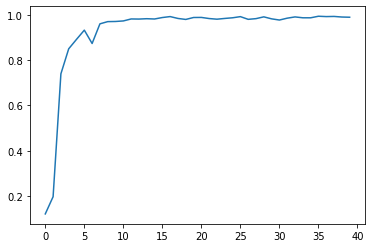

In [8]:
plt.plot(history.history['val_meanAP'])

Calculating Average Precision...: 74it [00:00, 735.11it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 1000it [00:01, 852.05it/s]


Validation meanAP: tf.Tensor(0.9937869752467199, shape=(), dtype=float64)


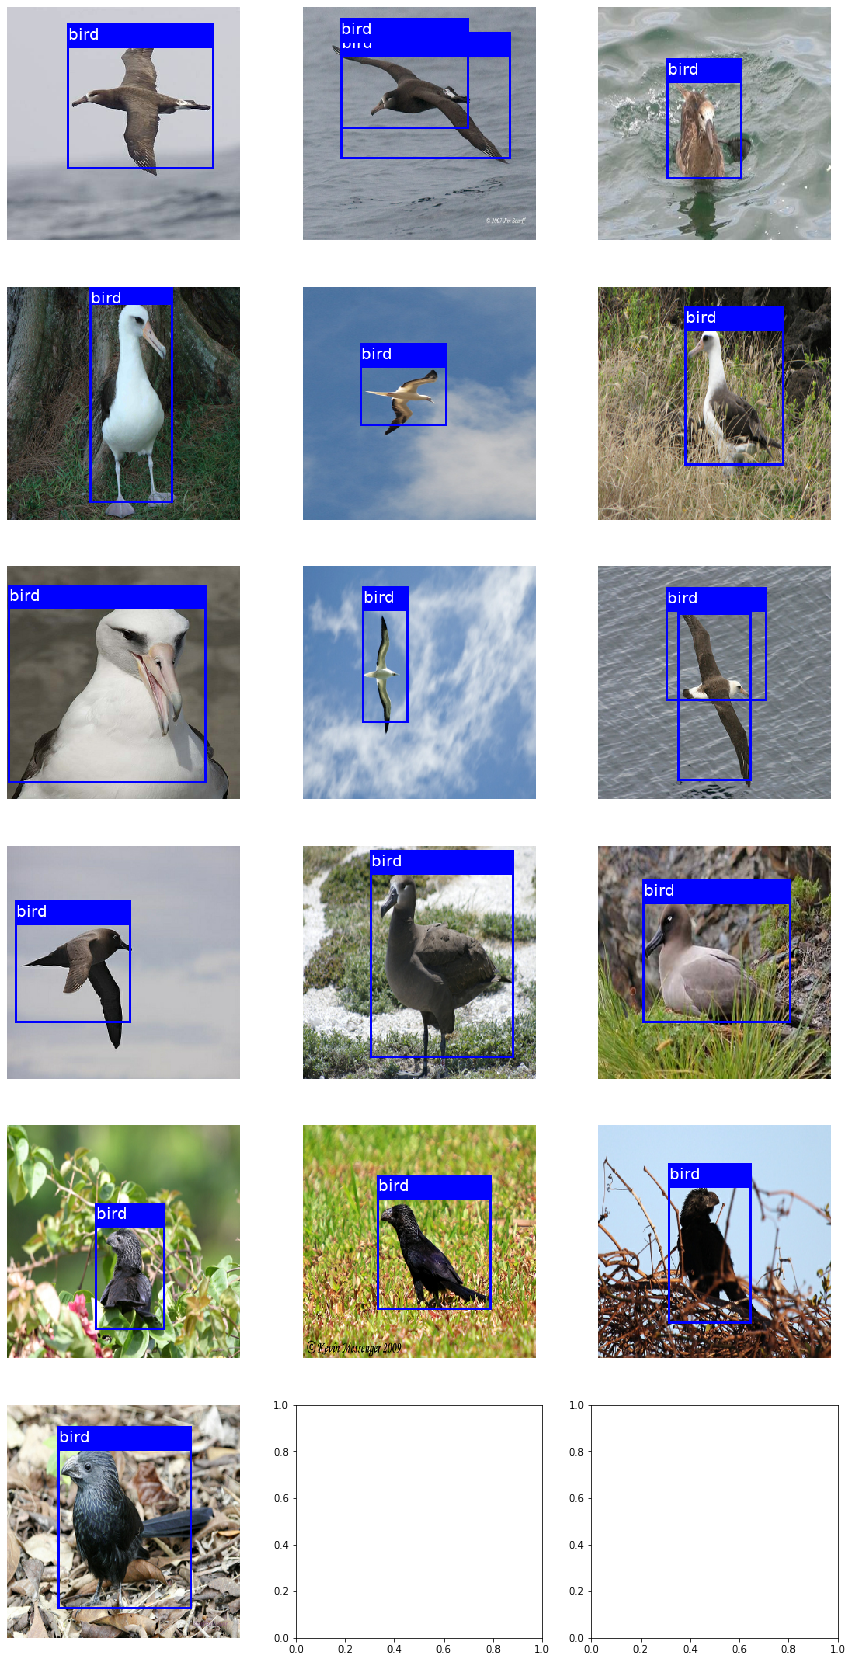

In [9]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'baseline_resnet50.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()